In [133]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.8024784999997792
GPU (s):
0.025956899999982852
GPU speedup over CPU: 30x


In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization


## Import data and preprocessing

In [135]:
#path of the data
x_train=pd.read_csv('csvTrainImages 13440x1024.csv',header = None).values
train_label =pd.read_csv('csvTrainLabel 13440x1.csv',header = None)

x_test=pd.read_csv('csvTestImages 3360x1024.csv',header = None).values
test_label =pd.read_csv('csvTestLabel 3360x1.csv',header = None)

In [136]:


train_label = train_label.squeeze()
test_label = test_label.squeeze()



# New Section

In [137]:
#arabic list words
characters = ["ا","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
characters_dict = dict(zip(np.arange(1,len(characters)+1), characters))

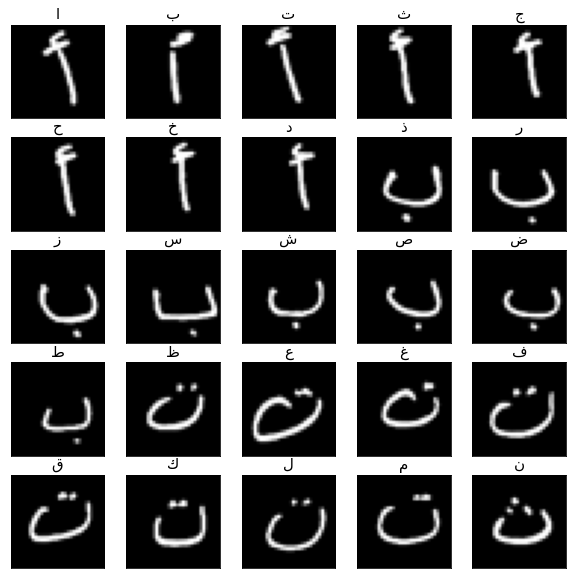

In [138]:
# ploting the aribic letters



train_label = train_label.map(characters_dict).values
test_label = test_label.map(characters_dict).values


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(32,32).T,"gray")
    plt.title(characters[i][0],fontsize = 15)
plt.show()

## ConvNet Model

In [139]:
x_train = (x_train).reshape([-1,32,32,1])
x_test = (x_test).reshape([-1,32,32,1])

In [140]:
x_train,train_label  = shuffle(x_train,train_label  )
x_test,test_label  = shuffle(x_test,test_label )

In [141]:
print("Train images shape: ", x_train.shape)
print("Train labels shape: ", y_train.shape)

print("Test images shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

Train images shape:  (13440, 32, 32, 1)
Train labels shape:  (13440, 1)
Test images shape:  (3360, 32, 32, 1)
Test labels shape:  (3360, 1)


In [142]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_label = lb.fit_transform(train_label)
test_label = lb.fit_transform(test_label)

In [143]:

train_datagen=ImageDataGenerator(
    zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1/255, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
    
)
train_generator=train_datagen.flow(
    x_train ,train_label  ,batch_size=64
)

test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow(
    x_test ,test_label  ,batch_size=64
 
)

In [144]:
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor="val_accuracy",
    patience= 3,
    verbose=1,
)
callbacks = [earlystop, learning_rate_reduction]

In [145]:
model=Sequential() 

model.add(Conv2D(32,(5,5), padding="same",activation=tf.nn.relu,input_shape=(32,32,1)))
model.add(Conv2D(32,(5,5), padding="same",activation=tf.nn.relu))
model.add(Conv2D(32,(5,5),activation=tf.nn.relu))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(1024,activation=tf.nn.relu))
model.add(Dense(1024,activation=tf.nn.relu))
model.add(Dropout(0.5))

model.add(Dense(28,activation=tf.nn.softmax))


model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_244 (Conv2D)         (None, 32, 32, 32)        832       
                                                                 
 conv2d_245 (Conv2D)         (None, 32, 32, 32)        25632     
                                                                 
 conv2d_246 (Conv2D)         (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 6272)              0         
                                                                 
 dense_24 (Dense)            (None, 1024)              6423552   
                                                      

In [146]:
model.compile(optimizer="adam" ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [147]:
model.fit(
    train_generator, 
    epochs=100,
    validation_data=test_generator,
    batch_size=32,
    callbacks=callbacks
)
                       

Epoch 1/100
210/210 [==============================] - 3s 13ms/step - loss: 2.3320 - accuracy: 0.2541 - val_loss: 1.2180 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 2/100
210/210 [==============================] - 3s 12ms/step - loss: 1.3557 - accuracy: 0.5231 - val_loss: 0.6729 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 3/100
210/210 [==============================] - 3s 13ms/step - loss: 0.9123 - accuracy: 0.6882 - val_loss: 0.5151 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 4/100
210/210 [==============================] - 3s 13ms/step - loss: 0.6925 - accuracy: 0.7690 - val_loss: 0.3447 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 5/100
210/210 [==============================] - 3s 12ms/step - loss: 0.6006 - accuracy: 0.8010 - val_loss: 0.3716 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 6/100
210/210 [==============================] - 3s 13ms/step - loss: 0.5205 - accuracy: 0.8296 - val_loss: 0.2789 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 7/100
210/210 [==============================] - 3s 

<AxesSubplot:>

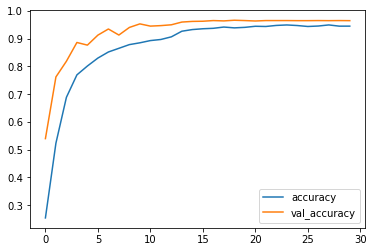

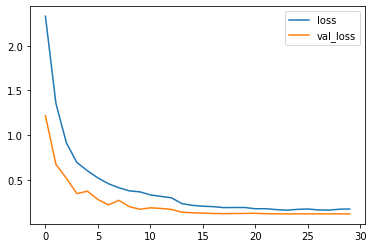

In [148]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [149]:
model.evaluate(test_generator)

53/53 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9643


[0.11734415590763092, 0.9642857313156128]